<a href="https://colab.research.google.com/github/butter-my-toast/Pioneer2024/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the ID:", gpu)
else:
    print("Failed to find GPU.")

Found a GPU with the ID: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
thefocusedvideo_path = '/content/drive/My Drive/pioneer training/focustest.mov'
theunfocusedvideo_path = '/content/drive/My Drive/pioneer training/unfocustest.mov'

In [ ]:
from tensorflow.keras import layers, models, applications, losses
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import gc

def extract_frames(video_path):

    frames = []
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()

    while success:
        frames.append(image)
        success, image = vidcap.read()

    del frames[1::2]
    return frames

focus = extract_frames("/content/drive/My Drive/pioneer training/xanderfocus.mov") + extract_frames("/content/drive/My Drive/pioneer training/nickfocus.mov") + extract_frames("/content/drive/My Drive/pioneer training/focus1.mov") + extract_frames("/content/drive/My Drive/pioneer training/focus2.mov") + extract_frames("/content/drive/My Drive/pioneer training/damov1.mov") + extract_frames("/content/drive/My Drive/pioneer training/damov3.mov") + extract_frames("/content/drive/My Drive/pioneer training/damov5.mov")
unfocus = extract_frames("/content/drive/My Drive/pioneer training/xanderunfocus.mov") + extract_frames("/content/drive/My Drive/pioneer training/nickunfocus.mov") + extract_frames("/content/drive/My Drive/pioneer training/unfocus1.mov") + extract_frames("/content/drive/My Drive/pioneer training/unfocus2.mov") + extract_frames("/content/drive/My Drive/pioneer training/damov2.mov") + extract_frames("/content/drive/My Drive/pioneer training/damov4.mov") + extract_frames("/content/drive/My Drive/pioneer training/damov6.mov")

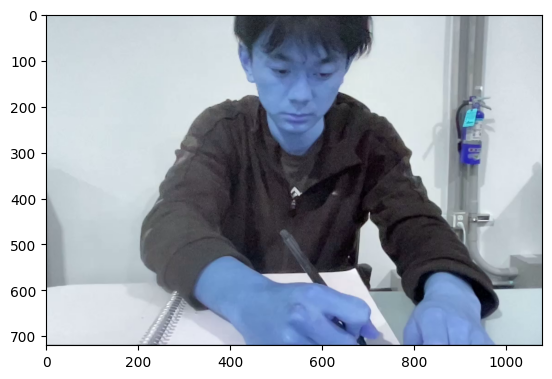

In [ ]:
plt.imshow(focus[0])

In [ ]:
def image_formatting(image):
    # converting pixel values (uint8) to float32 type
    image = tf.cast(image, tf.float32)
    # normalizing the data to be in range of -1, +1
    image = applications.resnet_v2.preprocess_input(image)
    # resizing all images to a shape of 224x*224*3
    image = tf.image.resize(image, (224, 224))
    return image

y = []
X = []
for i in range(len(focus)):
    image = image_formatting(focus[i])
    X.append(np.array(image))
    y.append(0)
for i in range(len(unfocus)):
    image = image_formatting(unfocus[i])
    X.append(np.array(image))
    y.append(1)

del focus
del unfocus
gc.collect()

0

In [ ]:
X = np.array(X)
y = np.array(y)
print(X)
print(y)
print(len(X))
print(len(y))

[[[[ 0.5529412   0.64705884  0.6862745 ]
   [ 0.5529412   0.64705884  0.6862745 ]
   [ 0.5529412   0.64705884  0.6862745 ]
   ...
   [ 0.57959765  0.6344996   0.68155843]
   [ 0.54509807  0.6156863   0.6627451 ]
   [ 0.5372549   0.60784316  0.654902  ]]

  [[ 0.5529412   0.64705884  0.6862745 ]
   [ 0.5529412   0.64705884  0.6862745 ]
   [ 0.5529412   0.64705884  0.6862745 ]
   ...
   [ 0.57100403  0.625906    0.6729648 ]
   [ 0.5529412   0.62352943  0.67058825]
   [ 0.54509807  0.6156863   0.6627451 ]]

  [[ 0.5529412   0.64705884  0.6862745 ]
   [ 0.54873955  0.6428572   0.6820729 ]
   [ 0.5471139   0.64123154  0.6804472 ]
   ...
   [ 0.57717     0.632072    0.6791308 ]
   [ 0.5529412   0.62352943  0.67058825]
   [ 0.5529412   0.62352943  0.67058825]]

  ...

  [[ 0.76139     0.80060565  0.8476645 ]
   [ 0.7526607   0.7918764   0.8389352 ]
   [ 0.74481755  0.78403324  0.83109206]
   ...
   [ 0.52156866  0.67058825  0.7411765 ]
   [ 0.5179276   0.6669472   0.7375354 ]
   [ 0.5137255  

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
del X
del y
gc.collect()

0

In [ ]:
# create the base model based on ResNet152V2
base_model = applications.ResNet152V2(
    weights='imagenet',  # Load weights pre-trained on the ImageNet dataset
    input_shape=(224, 224, 3),
    include_top=False) # do not include the classifier at the top

234545216/234545216 [==============================] - 4s 0us/step


In [ ]:
model = models.Sequential()

## TODO
# add the entire base_model as "first layer"
model.add(base_model)

# add a GlobalAveragePooling2D layer
model.add(layers.GlobalAveragePooling2D())

# add to the model a Dense layer with 256 neurons and ReLu activation
model.add(layers.Dense(256, activation="relu"))

# add to the model a Dense layer with 1 neurons and Sigmoid activation (Why??)
model.add(layers.Dense(1, activation="sigmoid"))

# do not train the first layer (ResNet/base_model) of the model as it is already trained
model.layers[0].trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 58856449 (224.52 MB)
Trainable params: 524801 (2.00 MB)
Non-trainable params: 58331648 (222.52 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [ ]:
print(y_train)
print(X_train.shape)
history_fc = model.fit(X_train, y_train,
                       batch_size=32, epochs=5,
                       validation_split=0.2)

[1 0 1 ... 1 1 1]
(1475, 224, 224, 3)
Epoch 1/5
37/37 [==============================] - 33s 490ms/step - loss: 0.0896 - accuracy: 0.9534 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 2/5
37/37 [==============================] - 10s 261ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/5
37/37 [==============================] - 10s 261ms/step - loss: 3.4754e-04 - accuracy: 1.0000 - val_loss: 9.4812e-04 - val_accuracy: 1.0000
Epoch 4/5
37/37 [==============================] - 10s 282ms/step - loss: 2.3149e-04 - accuracy: 1.0000 - val_loss: 6.2177e-04 - val_accuracy: 1.0000
Epoch 5/5
37/37 [==============================] - 10s 284ms/step - loss: 1.5743e-04 - accuracy: 1.0000 - val_loss: 5.2221e-04 - val_accuracy: 1.0000


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', test_accuracy)

6/6 [==============================] - 2s 409ms/step - loss: 0.0020 - accuracy: 1.0000
Test accuracy: 1.0


In [ ]:
#Find test accuracy:
y_hat = model.predict(X_test)   # Prediction on test
y_hat = np.round(y_hat)
y_hat = np.squeeze(y_hat)
print(y_hat)
test_acc = np.mean(y_hat==y_test)
print(y_test)
print("Test Accuracy: ",test_acc*100,"%")


6/6 [==============================] - 4s 212ms/step
[0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0.]
[0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0
 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 0
 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1
 0 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0]
Test Accuracy:  100.0 %


In [ ]:
correct_indices = np.nonzero(y_hat == y_test)[0]    # Gives list of correctly classified digits
incorrect_indices = np.nonzero(y_hat != y_test)[0]  # Gives list of index of misclassified digits

In [ ]:
for i, index in enumerate(incorrect_indices[:16]):
    plt.imshow(X_test[index])
    plt.title(f"Predicted {y_hat[index]}, Class {y_test[index]}")
    plt.show()

In [ ]:
del X_train
del X_test
del y_train
del y_test
gc.collect()

2003

In [ ]:
focustest = extract_frames(thefocusedvideo_path)
unfocustest = extract_frames(theunfocusedvideo_path)


In [ ]:
randomX = []
randomY = []
for i in range(len(focustest)):
    image = image_formatting(focustest[i])
    randomX.append(np.array(image))
    randomY.append(0)

for i in range(len(unfocustest)):
    image = image_formatting(unfocustest[i])
    randomX.append(np.array(image))
    randomY.append(1)

del focustest
del unfocustest
gc.collect()

0

In [ ]:
randomX = np.array(randomX)
randomY = np.array(randomY)
print(len(randomX))
print(len(randomY))

230
230


In [ ]:
random_pred = model.predict(randomX)
random_pred = np.round(random_pred)
random_pred = np.squeeze(random_pred)
test_acc = np.mean(random_pred == randomY)
print("Random Test Accuracy: ",test_acc*100,"%")


8/8 [==============================] - 3s 406ms/step
Random Test Accuracy:  100.0 %


In [ ]:
correct_indices = np.nonzero(random_pred == randomY)[0]    # Gives list of correctly classified digits
incorrect_indices = np.nonzero(random_pred != randomY)[0]  # Gives list of index of misclassified digits

In [ ]:
for i, index in enumerate(incorrect_indices[:]):
    plt.imshow(randomX[index])
    plt.title(f"Predicted {random_pred[index]}, Class {randomY[index]}")
    plt.show()

In [ ]:
tf.saved_model.save(model, 'model/')

In [ ]:
import shutil

shutil.make_archive('saved_model', 'zip', 'model')

'/content/saved_model.zip'

In [ ]:
!cp saved_model.zip "/content/drive/My Drive/saved_model.zip"
